In [1]:
import os
import time

import pandas as pd
import requests
# Remplacez 'votre_api_key' par votre clé API FRED
api_key = "9bc3e9a47cf483e7b4eeef9531d0f4f6"
base_url = "https://api.stlouisfed.org/fred/series/observations"
# Liste mise à jour des séries_id
series_ids = [
    # Produit Intérieur Brut (PIB)
    "GDP",
    "GDPC1",
    "GDPDEF",
    "RGDP",
    "RIP",
    # Prix à la Consommation
    "CPIAUCNS",
    "CPILFESL",
    "PPIACO",
    "CPIPSA",
    # Emploi et Marché du Travail
    "UNRATE",
    "U6RATE",
    "PAYEMS",
    "ICSA",
    "JOLTS",
    "MORATE",
    "OCC",
    # Production Industrielle
    "IP",
    "IPMAN",
    "IPG2211S",
    "IPG3114S",
    "IPG3131S",
    # Masse Monétaire et Réserves
    "M1SL",
    "M2SL",
    "M0SL",
    "RESBALNS",
    "M2",
    "M3",
    # Taux d'Intérêt
    "FEDFUNDS",
    "IR1420T",
    "IR3M",
    "IR1Y",
    "IR5Y",
    "DGS10",
    "DGS5",
    "DGS2",
    "DGS1",
    "DGS30",
    # Balance des Paiements et Commerce
    "BOPGSTB",
    "BOPBOT",
    "EXH2O",
    "USIMPM",
    "EXPGS",
    "IMPGS",
    "NETEXP",
    "CAD",
    # Défense et Dépenses Publiques
    "FYGFD",
    "FYGFDP",
    "GCEC1",
    "CNP",
    # Indices Boursiers et Marchés Financiers
    "SP500",
    "DJIA",
    "NASDAQ",
    "VIXCLS",
    "RUSSELL2000",
    # Consommation et Revenu
    "PCE",
    "PCED",
    "PCI",
    "PCEPI",
    "PCECTPI",
    # Emploi et Salaire
    "MSP",
    "EPO",
    "W430RC1",
    # Conditions de Crédit et Prêts
    "LOANS",
    "DTCOLNVHM",
    "DTB3",
    "DTB10",
    "DTCCL",
    "DTB4",
    "DTB6",
    # Productivité et Coûts
    "OPHPPI",
    "LPPI",
    "LPI",
    # Immobilier et Logement
    "SFRHBH",
    "HOUST",
    "SFRHPH",
    # Rendements et Inflation
    "T10YIE",
    "T5YIE",
    "T1YIE",
    # Réserves et Masse Monétaire
    "WALCL",
    "M2V",
    # Indices de Production
    "INDPRO",
    "IPMAN",
    "IPMFG",
    # Saisonnalité et Ajustements
    "SA",
    "NSA",
    # Autres Indicateurs Financiers
    "H15",
    "LIBOR",
    "OILPRICE",
]


# Fréquences à tester
frequencies = [
    "d",
    "w",
    "m",
    "q",
    "a",
]  # 'd' : daily, 'w' : weekly, 'm' : monthly, 'q' : quarterly, 'a' : annual


def fetch_data(series_id, api_key, frequency):
    params = {
        "api_key": api_key,
        "file_type": "json",
        "series_id": series_id,
        "sort_order": "asc",  # Trie les données de la plus ancienne à la plus récente
        "limit": 1000,  # Nombre maximum d'observations par page
        "frequency": frequency,
    }

    all_observations = []
    offset = 0

    while True:
        params["offset"] = offset
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            observations = data.get("observations", [])
            if not observations:
                break
            all_observations.extend(observations)
            offset += 1000
        else:
            print(
                f"Erreur lors de la récupération des données pour {series_id} avec la fréquence {frequency}: {response.status_code}"
            )
            break

        # Petite pause pour éviter les dépassements de limites d'API
        time.sleep(1)

    return all_observations


def get_data_for_series(series_id, api_key):
    data_list = []
    for frequency in frequencies:
        print(
            f"Tentative de récupération des données pour la série {series_id} avec la fréquence {frequency}"
        )
        observations = fetch_data(series_id, api_key, frequency)
        if observations:
            data_list.extend(
                {
                    "series_id": series_id,
                    "frequency": frequency,
                    "date": obs["date"],
                    "value": obs["value"],
                }
                for obs in observations
            )
            break  # Sort de la boucle si les données ont été trouvées
    return data_list


# Répertoire de sortie principal
base_output_dir = "data/series_names"

# Collecte des données et sauvegarde dans des fichiers Parquet
for series_id in series_ids:
    data_all = get_data_for_series(series_id, api_key)

    if data_all:
        # Convertir en DataFrame
        df = pd.DataFrame(data_all)

        # Déterminer la plage de dates
        min_date = df["date"].min()
        max_date = df["date"].max()
        date_range_str = f"{min_date}_{max_date}"

        # Créer le répertoire pour chaque série s'il n'existe pas
        series_output_dir = os.path.join(base_output_dir, series_id)
        os.makedirs(series_output_dir, exist_ok=True)

        # Exporter en Parquet
        parquet_file_name = f"data_{date_range_str}.parquet"
        parquet_file_path = os.path.join(series_output_dir, parquet_file_name)
        df.to_parquet(parquet_file_path, index=False)

        print(
            f"Les données pour la série {series_id} ont été exportées vers {parquet_file_path}"
        )
    else:
        print(f"Aucune donnée trouvée pour la série {series_id}")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.11/site-

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.11/site-

AttributeError: _ARRAY_API not found

Tentative de récupération des données pour la série GDP avec la fréquence d
Erreur lors de la récupération des données pour GDP avec la fréquence d: 400
Tentative de récupération des données pour la série GDP avec la fréquence w
Erreur lors de la récupération des données pour GDP avec la fréquence w: 400
Tentative de récupération des données pour la série GDP avec la fréquence m
Erreur lors de la récupération des données pour GDP avec la fréquence m: 400
Tentative de récupération des données pour la série GDP avec la fréquence q
Les données pour la série GDP ont été exportées vers data/series_names/GDP/data_1946-01-01_2024-04-01.parquet
Tentative de récupération des données pour la série GDPC1 avec la fréquence d
Erreur lors de la récupération des données pour GDPC1 avec la fréquence d: 400
Tentative de récupération des données pour la série GDPC1 avec la fréquence w
Erreur lors de la récupération des données pour GDPC1 avec la fréquence w: 400
Tentative de récupération des données pou

In [ ]:
import src.libs.transformation_trustia.volumes.VPC as VPC
import src.commons.logs as LOG
import src.commons.syn as SYN


request_api SYN()
log = LOG()

log.starting_application("VPC - FOREX USDCHF")

vpc = VPC(df)
vpc.show_footprint()

   Jour  Nombre de ticks réel  Nombre de ticks attendu  \
0     1           1000.000000               1000.00000   
1     2           1100.000000               1010.00000   
2     3           1210.000000               1030.00000   
3     4           1331.000000               1060.10000   
4     5           1464.100000               1100.50000   
5     6           1610.510000               1151.50100   
6     7           1771.561000               1213.50700   
7     8           1948.717100               1287.02801   
8     9           2143.588810               1372.68409   
9    10           2357.947691               1471.21045   

   Stockage par jour (KB)  Stockage cumulé (KB)  
0                6.000000              6.000000  
1                6.600000             12.600000  
2                7.260000             19.860000  
3                7.986000             27.846000  
4                8.784600             36.630600  
5                9.663060             46.293660  
6          

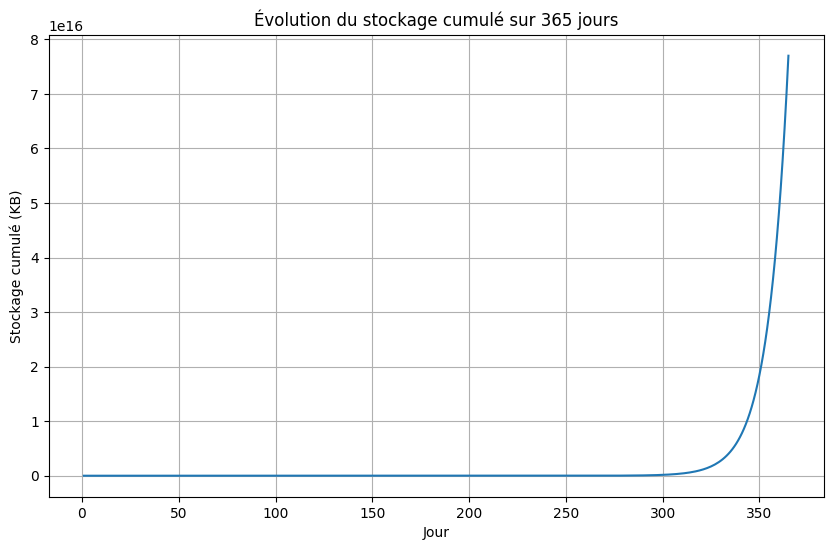

In [2]:
# Importer les bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres initiaux
tick_in_balance = 1  # Nombre de ticks qui prennent soit 1 soit -1
valeur_initiale_ticks = 1000  # Valeur d'initialisation des ticks attendus
valeur_initiale_imbalance = 0  # Valeur d'initialisation de l'imbalance attendue
alpha = 0.1  # Facteur d'actualisation EWMA du nombre de ticks
nombre_jours = 365  # Nombre de jours à simuler

# Initialiser les listes pour stocker les résultats
jours = np.arange(1, nombre_jours + 1)
nombre_ticks_reel = np.zeros(nombre_jours)
nombre_ticks_attendu = np.zeros(nombre_jours)
stockage_par_jour = np.zeros(nombre_jours)
stockage_cumule = np.zeros(nombre_jours)

# Valeurs initiales
nombre_ticks_reel[0] = valeur_initiale_ticks
nombre_ticks_attendu[0] = valeur_initiale_ticks
stockage_par_jour[0] = 6  # En kilobytes
stockage_cumule[0] = stockage_par_jour[0]

# Boucle de simulation pour chaque jour
for t in range(1, nombre_jours):
    # Simuler le nombre réel de ticks (exemple avec une croissance exponentielle)
    nombre_ticks_reel[t] = nombre_ticks_reel[t-1] * (1 + alpha)

    # Mettre à jour le nombre de ticks attendu avec l'EWMA
    nombre_ticks_attendu[t] = alpha * nombre_ticks_reel[t] + (1 - alpha) * nombre_ticks_attendu[t-1]

    # Calculer le stockage pour le jour t
    stockage_par_jour[t] = (nombre_ticks_reel[t] / valeur_initiale_ticks) * 6  # En kilobytes

    # Calculer le stockage cumulé
    stockage_cumule[t] = stockage_cumule[t-1] + stockage_par_jour[t]

# Créer un DataFrame pour visualiser les résultats
df = pd.DataFrame({
    'Jour': jours,
    'Nombre de ticks réel': nombre_ticks_reel,
    'Nombre de ticks attendu': nombre_ticks_attendu,
    'Stockage par jour (KB)': stockage_par_jour,
    'Stockage cumulé (KB)': stockage_cumule
})

# Afficher les 10 premiers jours
print(df.head(10))

# Tracer l'évolution du stockage cumulé
plt.figure(figsize=(10, 6))
plt.plot(df['Jour'], df['Stockage cumulé (KB)'])
plt.title('Évolution du stockage cumulé sur {} jours'.format(nombre_jours))
plt.xlabel('Jour')
plt.ylabel('Stockage cumulé (KB)')
plt.grid(True)
plt.show()
